# Prototype for analytical model classes

The aim of this worksheet is to experiment and design a set of classes for expressing analytical models for well test interpretation. The general idea is that there should be a parent generic class and a set of derived classes allowing to avoid repeating code.

In this first prototype, I consider only the generic parent class and two daughter classes.

Nov. 7 2019 - P. Renard


In [85]:
import sys
sys.path.append("..")
import openhytest as ht

import numpy as np
from scipy.special import expn as E1
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

#import math

In [86]:
# Read a data set to test ideas
df = pd.read_csv('../data/ths_ds1.txt',header=None,sep=" ",names=['t','s'])
df2 = pd.read_csv('../data/thn_ds1.txt',header=None,sep=" ",names=['t','s'])


Below is the part where the classes are defined in order to test the concept.

The first thing is to define a generic class AnalyticalModels of analytical models that should contain all the generic functionalities.  Then, we derive two examples of daughter classes: the theis and theis_noflow models. 

The theis_noflow model is wrong (wrong equations and parametrizations and needs to be corrected), but the principle seems to work.

The next steps would be to implement:
- the fit function
- one or a pair of examples with laplace domain solution


In [98]:
# Utilities

def get_logline(df):
    
    logt = np.log10( df.t ).values
    Gt = np.array( [logt, np.ones(logt.shape)] )
    p = np.linalg.inv( Gt.dot(Gt.T) ).dot(Gt).dot(df.s) 
    p[1] = 10**( -p[1]/p[0] )

    return p

    
# Parent generic class

class AnalyticalModels():
    def __init__(self,Q=None,r=None):
        self.Q = Q
        self.r = r
    
    def _dimensionless_time(self,p,t):
        return (t/(0.5628*p[1])) * 0.25
    
    def _dimensional_drawdown(self,p,sd):
        return (sd*p[0]*2)/2.302585092994046
    
    def dimensionless(self,td):
        print("Warning - undefined")
        return None
    
    def __call__(self,t):
        print("Warning - undefined")
        return None
    
    def T(self,p):
        return 0.1832339 * self.Q / p[0]
    
    def S(self,p):
        return 2.458394*self.T(p)*p[1]/self.r**2 
    
    def RadiusOfInfluence(self,p,t):   #THIS FUNCTION CHANGES FOR NO-FLOW BOUNDARY! t[len(t)-1] -> p[3]
        return 2*np.sqrt( self.T(p) * t[len(t)-1] / self.S(p) ) 
    
    def trial(self, p, df): #loglog included: derivatives are missing at the moment.
        figt = plt.figure()
        ax1 = figt.add_subplot(211)
        ax2 = figt.add_subplot(212)
        ax1.loglog(df.t, self.__call__(p,df.t), df.t, df.s,'o' )
        ax1.set_ylabel('s')
        ax1.grid()
        ax1.minorticks_on()
        ax1.grid(which='major', linestyle='--', linewidth='0.5', color='black')
        ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        ax2.semilogx(df.t, self.__call__(p,df.t), df.t, df.s,'o' )
        ax2.set_ylabel('s')
        ax2.set_xlabel('t')
        ax2.grid()
        ax2.minorticks_on()
        ax2.grid(which='major', linestyle='--', linewidth='0.5', color='black')
        ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        plt.show()
        print( 'T = ', self.T(p) ,'m2/s')
        print( 'S = ', self.S(p) ,'-')
        print( 'Ri = ',self.RadiusOfInfluence(p,df.t),'m' )
        
        
    def fit(self, p,  df, option='lm', output='all'):   
        t = df.t
        s = df.s
        # costfunction
        def fun(p, t, s):
            return np.array(s) - self.__call__(p,t)

        if option == 'lm':
            # Levenberg-Marquard -- Default
            res_p = least_squares(fun, p, args=(t,s), method='lm', xtol=1e-10, verbose=1)      
        elif option == 'trf':
            # Trust Region Reflective algorithm
            res_p = least_squares(fun, p, jac='3-point', args=(t,s), method='trf', verbose=1)
        else: 
            raise Exception('Specify your option')

        if output == 'all': #-- Default
            #define regular points to plot the calculated drawdown
            tc = np.logspace(np.log10(t[0]), np.log10(t[len(t)-1]),  num = len(t), endpoint = True, base = 10.0, dtype = np.float64)
            sc = self.__call__(res_p.x,tc)
            mr = np.mean(res_p.fun)
            sr = 2 * np.nanstd(res_p.fun)
            rms = np.sqrt(np.mean(res_p.fun**2))
            return res_p.x, tc, sc, mr, sr, rms
        elif output == 'p':
            return res_p.x
        elif output  == 'Detailled':
            #define regular points to plot the calculated drawdown
            tc = np.logspace(np.log10(t[0]), np.log10(t[len(t)-1]),  num = len(t), endpoint = True, base = 10.0, dtype = np.float64)
            sc = self.__call__(res_p.x,tc)
            mr = np.mean(res_p.fun)
            sr = 2 * np.nanstd(res_p.fun)
            rms = np.sqrt(np.mean(res_p.fun**2))
            return res_p, tc, sc, mr, sr, rms
        else:
            raise Exception('The output needs to specified: p or all')    
            
# Derived daughter classes

class theis(AnalyticalModels):
    
    def dimensionless(self, td):
        return 0.5*E1(1,0.25/td)
      
    def dimensionless_logderivative(self, td):
        return 0.5*np.exp(-0.25/td)
    
    def __call__(self, p, t):
        td = self._dimensionless_time(p,t)
        sd = self.dimensionless( td )
        s = self._dimensional_drawdown(p,sd)
        return s
    
    def guess_params(self, df):
        n = len(df)/3
        return get_logline(df[df.index>n])
    
    def plot_typecurve(self):
        td = np.logspace(-1, 4)
        sd = self.dimensionless(td)
        dd = self.dimensionless_logderivative(td)

        plt.loglog(td,sd,td,dd,'--')
        plt.xlabel('$t_D$')
        plt.ylabel('$s_D$')
        plt.xlim((1e-1,1e4))
        plt.ylim((1e-2,10))
        plt.grid('True')
        plt.legend(['Theis','Derivative'])
        plt.show()

    
class theis_noflow(AnalyticalModels):
    
    def dimensionless(self, td, ri): #CHANGED FROM - TO +, BUT THERE IS STILL SOMETHING WRONG.
        return 0.5*(E1(1, 0.25/td)+E1(1, 0.25/td*ri**2))
    
    #NEW PART
    def dimensionless_logderivative(self, td, ri):
        return 0.5*(np.exp(-0.25/td)+np.exp(-0.25/td*ri**2))
    
    def __call__(self, p, t):
        ri =  p[2] / p[1]
        td = self._dimensionless_time(p, t)
        sd = self.dimensionless(td, ri) 
        s = self._dimensional_drawdown(p, sd)
        return s
    
    def guess_params(self, df):
        header = df.head(0)
        header = list(header)
        der1 = ht.ldiffs(df)
        der2 = ht.ldiffs(der1)
        p[2] = der2[header[0]][der2[header[1]].idxmax()] #ti: time of intersection between the 2 straight lines
        p[0] = der1['s'][len(der1)-1]*2.30/2; #a: Jacobian straight line
        p[1] = 10**(p[0]*np.log10((df[header[0]][len(df)-1])**2/p[2]-df[header[1]][len(df)-1])/p[0]) #t0: intercept of the Jacob straight line 
        return p
    
    def plot_typecurve(self, ri=10.0):
        td = np.logspace(-1, 4)
        sd = self.dimensionless(td, ri)
        dd = self.dimensionless_logderivative(td, ri)
        
        plt.loglog(td, sd, td, dd, '--')
        plt.xlabel('$t_D$')
        plt.ylabel('$s_D$')
        plt.xlim((1e-1, 1e4))
        plt.ylim((1e-2, 10))
        plt.grid('True')
        plt.legend(['Theis_noflow', 'Derivative'])
        plt.show()

# How to create a type curve

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


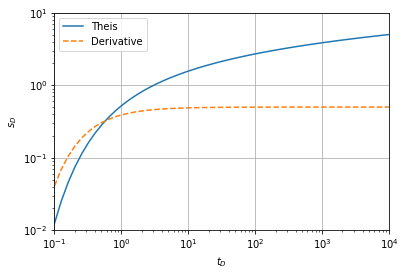

In [99]:
abaque = theis()
abaque.plot_typecurve()

# How to adjust manually a Theis model

estimated parameter vector: [  1.70038569 341.82452507]


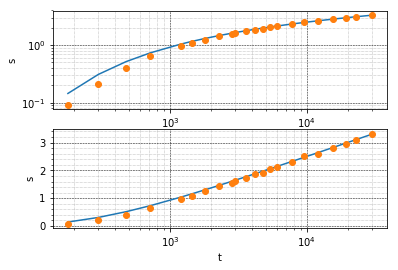

T =  0.0014965736409743885 m2/s
S =  2.0122075805838408e-05 -
Ri =  2987.4681130830586 m


In [100]:
modele = theis(Q=1.3888e-2,r=250)
p = modele.guess_params(df)
print("estimated parameter vector:",p)
modele.trial(p,df)


In [109]:
p, tc, sc, mr, sr, rms = modele.fit(p, df, option='trf')

`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 8.4643e-03, final cost 8.4643e-03, first-order optimality 2.18e-10.


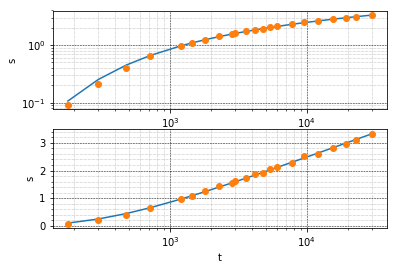

T =  0.001425123529580095 m2/s
S =  2.310198969702248e-05 -
Ri =  2720.772224664237 m


In [110]:
modele.trial(p,df)

# Moving to no flow model

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


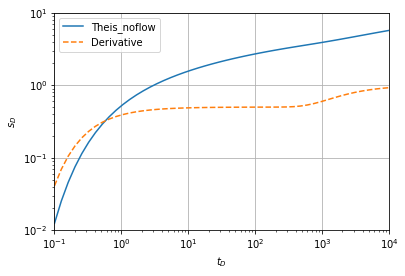

In [199]:
thn = theis_noflow()
thn.plot_typecurve(ri=80)

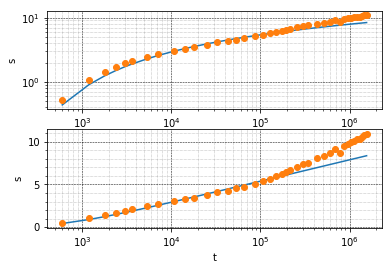

T =  0.000967474992 m2/s
S =  0.0041919911860385205 -
Ri =  1198.2096500929656 m


In [200]:
thn = theis_noflow(Q=0.0132,r=20)
p = [2.5,705,173671]
thn.trial(p,df2) 

estimated parameter vector: [2.4001626310105513, 21660952.643204335, 111659.2542740663]


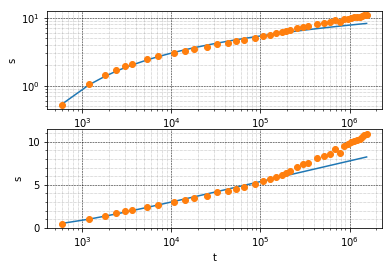

T =  0.001007718164073594 m2/s
S =  134.15539292887365 -
Ri =  6.835788152017683 m


In [201]:
p = thn.guess_params(df2)
print("estimated parameter vector:",p)
thn.trial(p,df2)